--- Parsing Sniper results from: /home/skataoka26/COSC_498/miniMXE/results/sniper_llc_2mb_16w_20251002T020032Z ---
Sniper parse complete. Merged DataFrame shape: (12, 19)
Sniper columns found: ['benchmark', 'config', 'time_s', 'energy_exact_J', 'leak_J', 'dyn_exact_nJ', 'dyn_exact_J', 'ipc', 'time_ns', 'l3_miss_rate_pct', 'l3_miss_text', 'l3_accesses_db', 'l3_misses_db', 'l3_read_hits', 'l3_write_hits', 'l3_writebacks', 'l3_evictions', 'l3_misses_custom', 'avg_l3_hit_ns']
--------------------

--- Parsing DynamoRIO logs from: /home/skataoka26/COSC_498/miniMXE/results_trace/logs with prefix '20250929T203551Z' ---
Found and processed 12 matching log files.
DynamoRIO parse complete. DataFrame shape: (12, 40)
DynamoRIO columns found: ['scope', 'reads', 'writes', 'bytes_read', 'bytes_written', 'uniq_lines', 'uniq_pages', 'footprint_bytes', 'global_footprint_bytes', 'H_line', 'H_page', 'H_stride', 'reuse_rate', 'avg_stride', 'avg_line_stride', 'p_stride_le_64', 'p50_strideB', 'p90_strideB', 

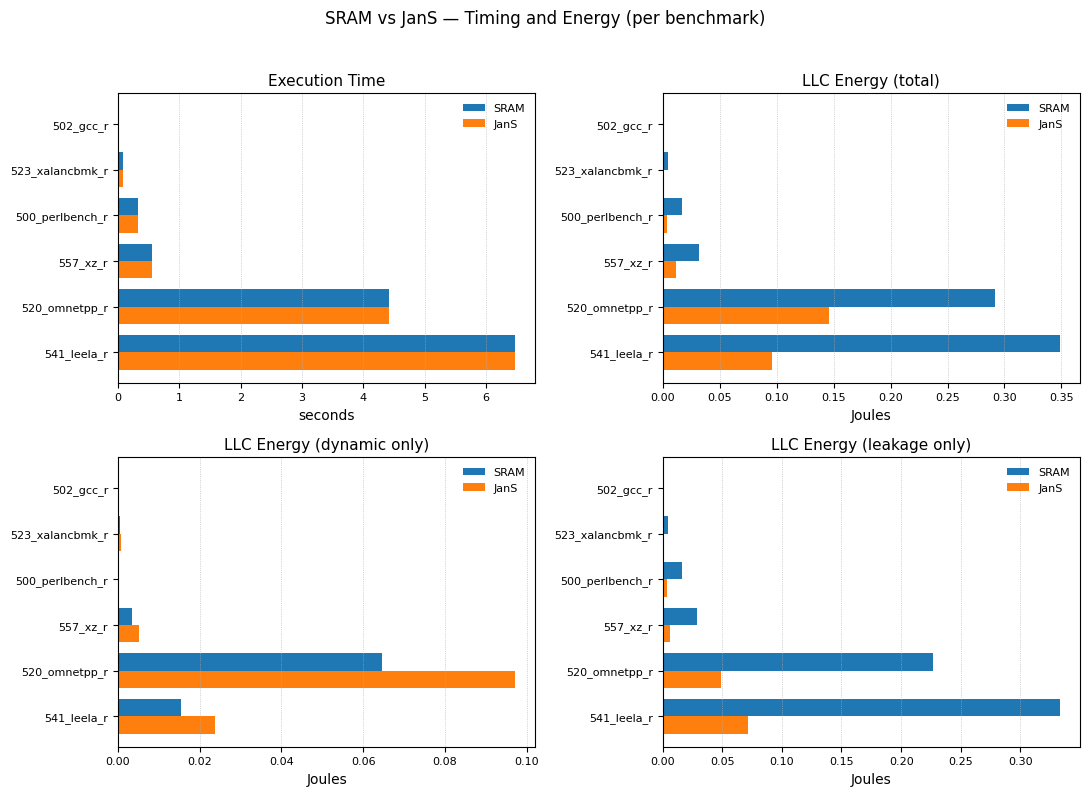

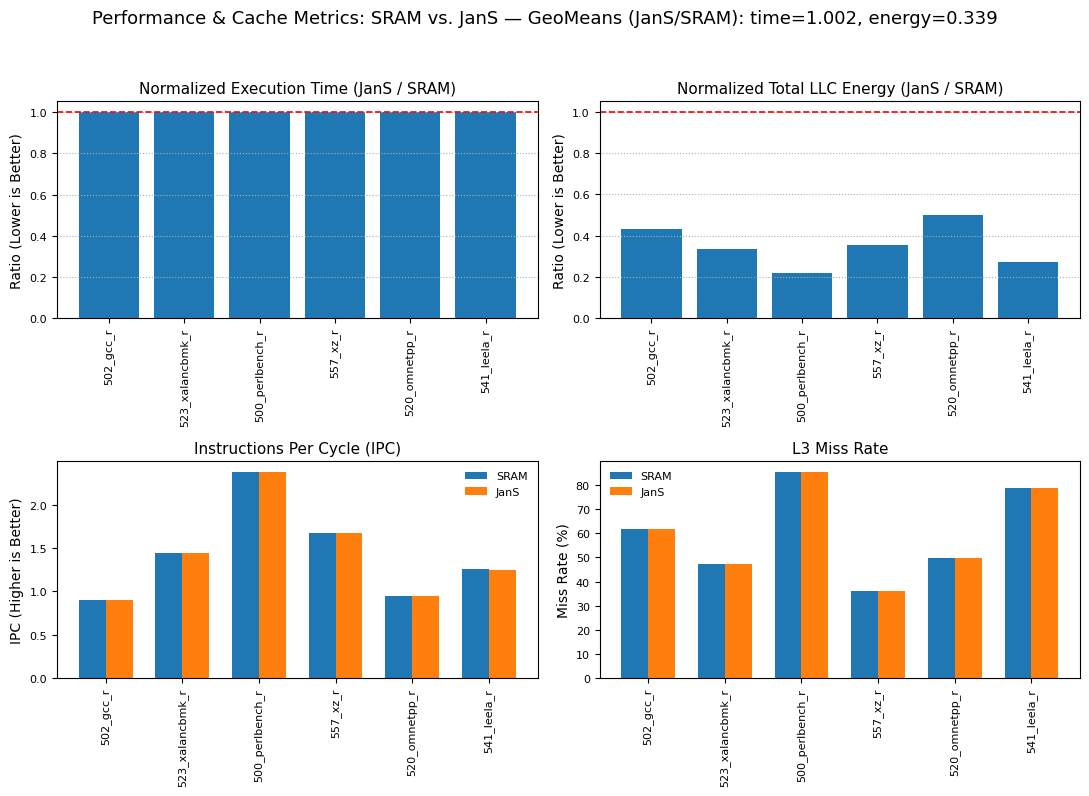

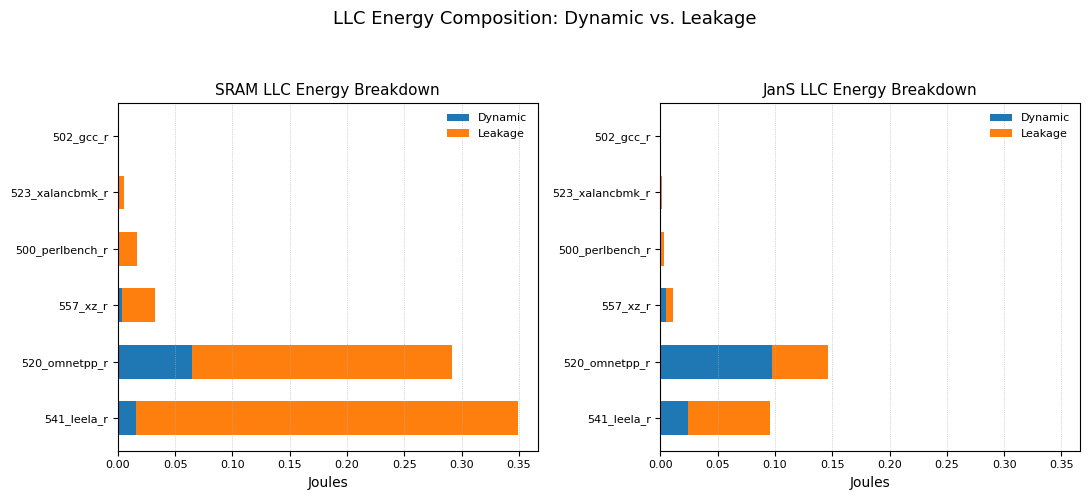

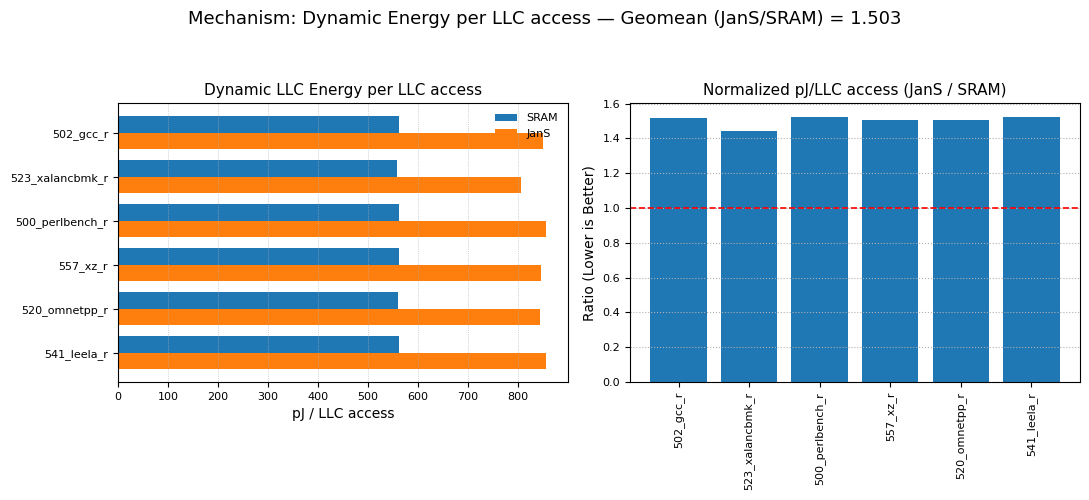

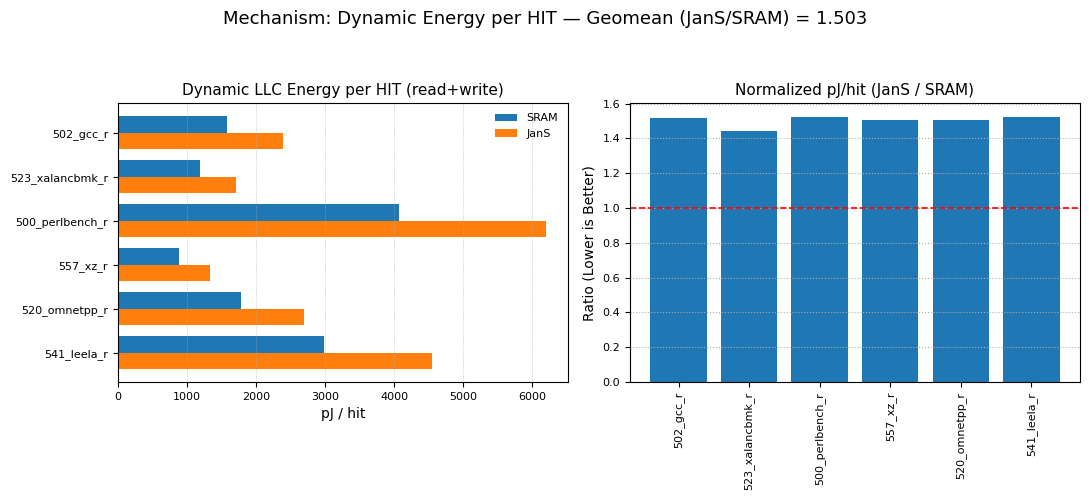

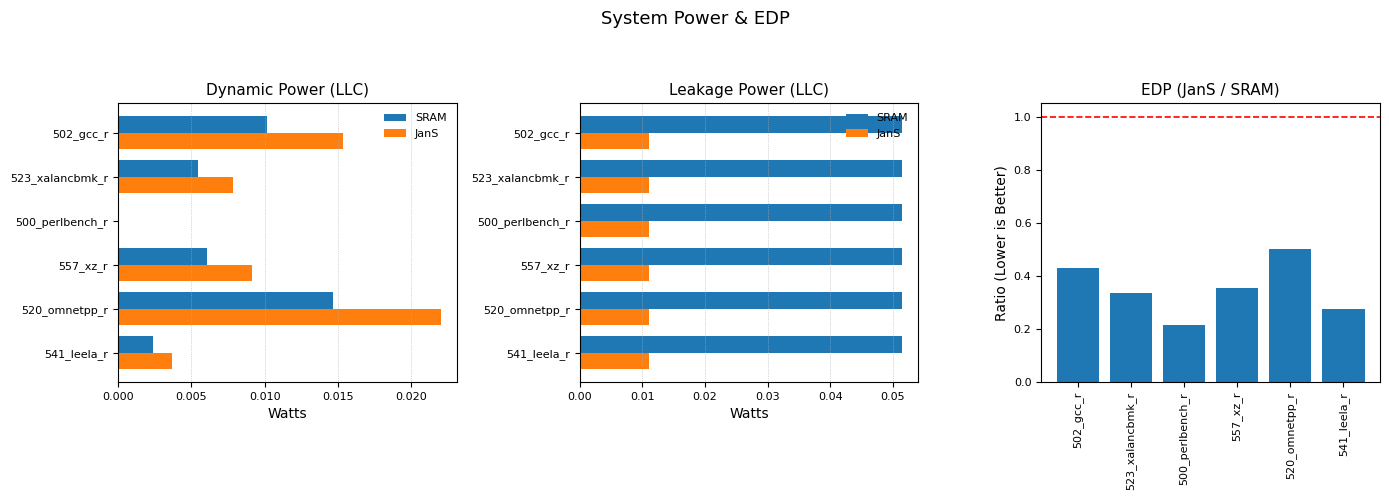

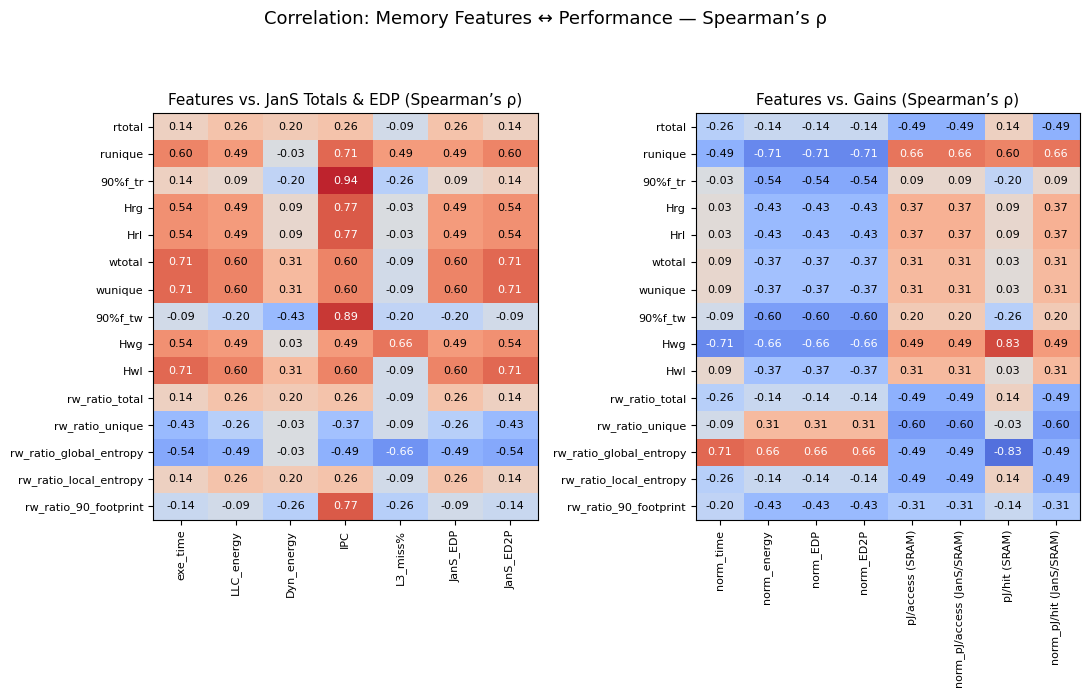

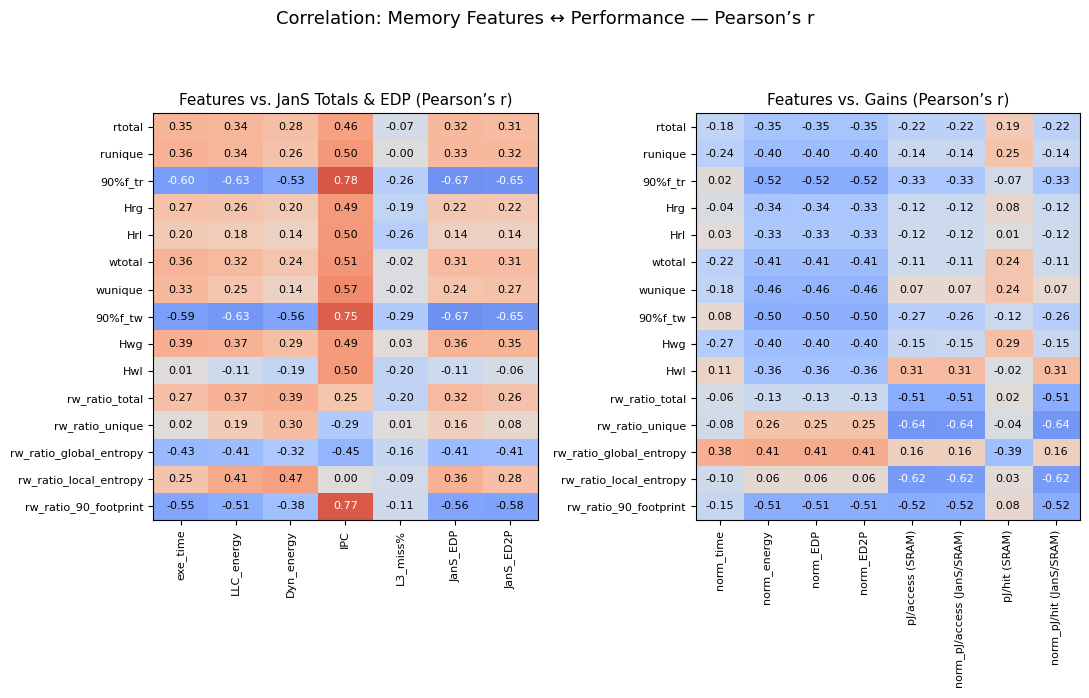

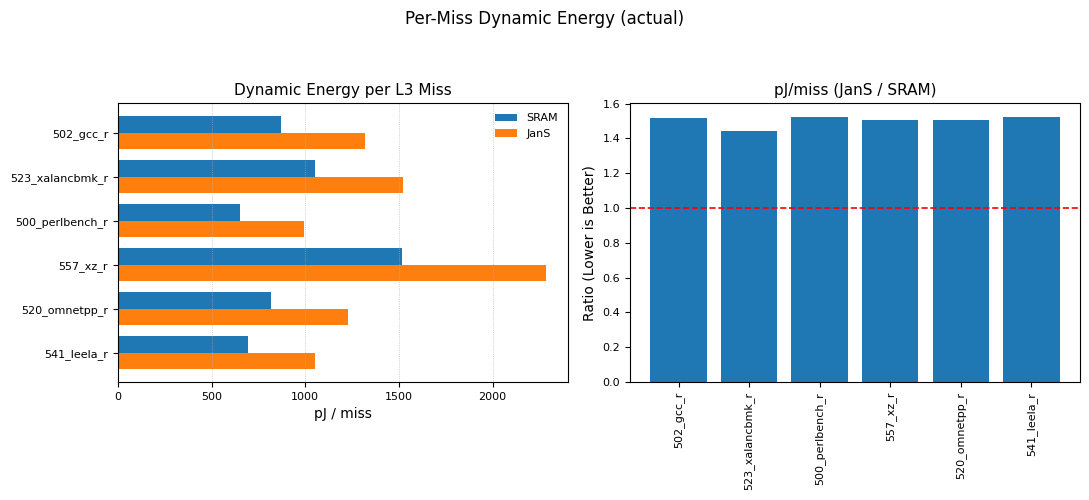

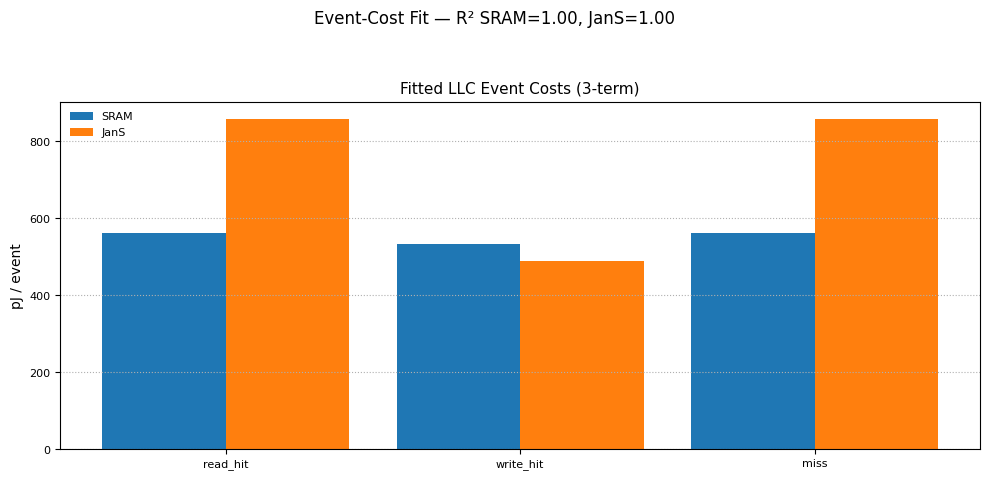

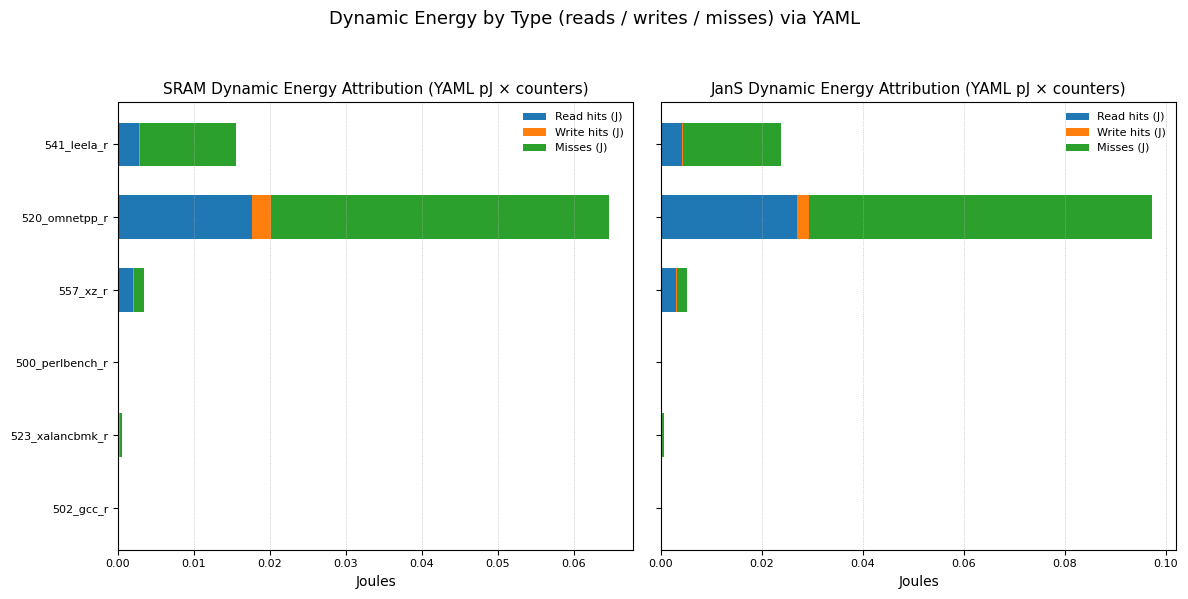

In [4]:
#!/usr/bin/env python3

import os
import re
import math
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Optional: YAML energy parsing (PyYAML)
try:
    import yaml  # type: ignore
except Exception:
    yaml = None
    warnings.warn("PyYAML not available — YAML-based energy attribution will be skipped.")

# -----------------------------
# Absolute paths (edit if needed)
# -----------------------------
RUN_IDS = {
    "Baseline (JanS, 2MB, 16 Way)": "sniper_roi1000_fixedcap2m_20250927T171235Z",
    "JanS, 2MB, 8 Way": "sniper_assoc_jans2mb_8way_20250929T024544Z",
    "JanS, 16MB, 16 Way": "sniper_cap_equal_16mb_20250929T024544Z",
    "JanS, 32MB, 16 Way": "sniper_cap_equal_32mb_20250929T024544Z",
    "ChungS, 2MB, 16 Way": "sniper_dev_chungs_2mb_20250929T024350Z",
    "UmekiS, 2MB, 16 Way": "sniper_dev_umekis_2mb_20250929T024536Z",
    "XueS, 2MB, 16 Way": "sniper_dev_xues_2mb_20250929T024537Z",
}
SNIPER_RESULTS_DIR = \
    f"/home/skataoka26/COSC_498/miniMXE/results/{RUN_IDS['Baseline (JanS, 2MB, 16 Way)']}"
# override to the latest explicit run dir if desired
SNIPER_RESULTS_DIR = \
    "/home/skataoka26/COSC_498/miniMXE/results/sniper_llc_2mb_16w_20251002T020032Z"
DYNAMORIO_LOGS_DIR = \
    "/home/skataoka26/COSC_498/miniMXE/results_trace/logs"
TIMESTAMP_PREFIX = "20250929T203551Z"  # prefix used in DynamoRIO filenames

# Path to the YAML used to launch Sniper (for pJ numbers)
YAML_CONFIG_PATH = \
    "/home/skataoka26/COSC_498/miniMXE/config/sniper_2mb_16w_nvsim.yaml"

# -----------------------------
# Utilities
# -----------------------------
def safe_div(numer, denom):
    numer = np.array(numer, dtype=float)
    denom = np.array(denom, dtype=float)
    with np.errstate(divide='ignore', invalid='ignore'):
        out = np.where((denom > 0) & np.isfinite(denom), numer / denom, np.nan)
    return out

def geomean(values):
    vals = np.array([v for v in np.ravel(values) if v > 0 and np.isfinite(v)], dtype=float)
    return float(np.exp(np.mean(np.log(vals)))) if len(vals) else np.nan

# --- statistics helpers ---
def bootstrap_spearman_ci(x, y, n_boot=10000, alpha=0.05, random_state=0):
    rng = np.random.default_rng(random_state)
    mask = np.isfinite(x) & np.isfinite(y)
    x0 = np.array(x)[mask]
    y0 = np.array(y)[mask]
    n = len(x0)
    if n < 3:
        return (np.nan, np.nan, np.nan, n)
    obs = pd.Series(x0).corr(pd.Series(y0), method="spearman")
    boots = []
    for _ in range(n_boot):
        idx = rng.integers(0, n, n)
        xi = x0[idx]
        yi = y0[idx]
        try:
            r = pd.Series(xi).corr(pd.Series(yi), method="spearman")
        except Exception:
            r = np.nan
        boots.append(r)
    boots = np.array([b for b in boots if np.isfinite(b)])
    if boots.size == 0:
        return (obs, np.nan, np.nan, n)
    lo = np.percentile(boots, 100 * alpha / 2.0)
    hi = np.percentile(boots, 100 * (1 - alpha/2.0))
    return (obs, lo, hi, n)

# -----------------------------
# Parsing helpers
# -----------------------------
def parse_sniper(base_dir):
    """
    Walk output_* folders, read summary.csv and energy_bounds.csv,
    merge them on (benchmark, config). Return a tidy DataFrame.
    We keep LLC event counters (accesses, hits, misses, reads, writes, evicts) when present.
    """
    energy_rows = []
    summary_rows = []
    print(f"--- Parsing Sniper results from: {base_dir} ---")
    for root, _, files in os.walk(base_dir):
        if os.path.basename(root).startswith("output_") and "summary.csv" in files and "energy_bounds.csv" in files:
            energy_path = os.path.join(root, "energy_bounds.csv")
            summary_path = os.path.join(root, "summary.csv")

            e = pd.read_csv(energy_path)
            s = pd.read_csv(summary_path)

            # Keep columns we use from energy
            e_keep = [
                "benchmark", "config", "time_s",
                "energy_exact_J", "leak_J", "dyn_exact_nJ"
            ]
            e = e[[c for c in e_keep if c in e.columns]].copy()

            # Base columns we want from summary
            s_base = ["benchmark", "config", "ipc", "time_ns", "l3_miss_rate_pct"]
            keep_s = [c for c in s_base if c in s.columns]

            # Keep any plausible LLC event columns
            for col in s.columns:
                cl = col.lower()
                if ("l3" in cl or "llc" in cl) and (
                    "access" in cl or "read" in cl or "write" in cl or "hit" in cl or "miss" in cl or "evict" in cl or "wb" in cl or "writeback" in cl
                ):
                    if col not in keep_s:
                        keep_s.append(col)

            s = s[keep_s].copy()

            # Numeric coercion
            for col in ["time_s", "energy_exact_J", "leak_J", "dyn_exact_nJ"]:
                if col in e.columns:
                    e[col] = pd.to_numeric(e[col], errors="coerce")

            for col in s.columns:
                if col not in ("benchmark", "config"):
                    s[col] = pd.to_numeric(s[col], errors="coerce")

            # Convert nJ -> J
            if "dyn_exact_nJ" in e.columns:
                e["dyn_exact_J"] = e["dyn_exact_nJ"] * 1e-9

            energy_rows.append(e)
            summary_rows.append(s)

    if not energy_rows or not summary_rows:
        raise FileNotFoundError(
            "Could not find summary.csv and energy_bounds.csv in output_* directories under: " + base_dir
        )

    E = pd.concat(energy_rows, ignore_index=True)
    S = pd.concat(summary_rows, ignore_index=True)

    df = pd.merge(E, S, on=["benchmark", "config"], how="inner")

    # minimal sanity
    df = df.dropna(subset=["benchmark", "config", "time_s", "energy_exact_J"])
    print(f"Sniper parse complete. Merged DataFrame shape: {df.shape}")
    print(f"Sniper columns found: {df.columns.tolist()}")
    print("-" * 20)
    return df


def _kv_from_line(s: str) -> dict:
    """Extract numeric key=value pairs from one rwstats line. 'scope' handled separately."""
    kv = {}
    m = re.search(r"\bscope=(\w+)", s)
    if m:
        kv["scope"] = m.group(1)

    for k, v in re.findall(r"([A-Za-z0-9_]+)=([+\-]?(?:\d+(?:\.\d*)?|\.\d+)(?:[eE][+\-]?\d+)?|nan)", s):
        try:
            kv[k] = float("nan") if v.lower() == "nan" else float(v)
        except Exception:
            pass
    return kv


def parse_dynamorio(logs_dir, ts_prefix):
    """
    Parse DynamoRIO log files. For each file, grab the LAST stats-like line
    (lines contain 'scope='). File name format: {ts_prefix}_<benchmark>_instr.rwstats.log
    """
    rows = []
    print(f"\n--- Parsing DynamoRIO logs from: {logs_dir} with prefix '{ts_prefix}' ---")
    if not os.path.isdir(logs_dir):
        print("DynamoRIO logs directory not found. Returning empty DataFrame.")
        print("-" * 20)
        return pd.DataFrame()

    found_files = 0
    for fname in os.listdir(logs_dir):
        if not (fname.startswith(ts_prefix) and fname.endswith("_instr.rwstats.log")):
            continue
        m = re.match(rf"{re.escape(ts_prefix)}_(.+?)_instr\.rwstats\.log$", fname)
        if not m:
            continue

        found_files += 1
        benchmark = m.group(1)
        fpath = os.path.join(logs_dir, fname)

        last = None
        with open(fpath, "r", errors="ignore") as f:
            for line in f:
                t = line.strip()
                if "scope=" in t and "=" in t:
                    last = t

        if not last:
            continue

        kv = _kv_from_line(last)
        kv["benchmark"] = benchmark
        rows.append(kv)

    print(f"Found and processed {found_files} matching log files.")
    df = pd.DataFrame(rows) if rows else pd.DataFrame()
    if not df.empty:
        print(f"DynamoRIO parse complete. DataFrame shape: {df.shape}")
        print(f"DynamoRIO columns found: {df.columns.tolist()}")
    else:
        print("DynamoRIO parse complete. No data found, returning empty DataFrame.")
    print("-" * 20)
    return df


# -----------------------------
# LLC event helpers (NEW: explicit access/hit/miss detection)
# -----------------------------
def _series_or_none(df, colname):
    if colname in df.columns:
        s = pd.to_numeric(df[colname], errors="coerce")
        return s if s.notna().any() else None
    return None


def _choose_col(df_config, must_terms, maybes=("l3", "llc")):
    """Best-populated column whose lowercase name contains all must_terms and any maybes."""
    best = None
    best_pop = -1
    for c in df_config.columns:
        cl = c.lower()
        if all(t in cl for t in must_terms) and any(m in cl for m in maybes):
            ser = pd.to_numeric(df_config[c], errors="coerce")
            pop = ser.notna().sum()
            if pop > best_pop:
                best, best_pop = c, pop
    return best


def detect_total_accesses(df_config):
    """
    Prefer a direct total-access column:
      1) l3_accesses_db / llc_accesses_db (or ROI variants)
      2) l3_accesses / llc_accesses
      3) Fallback: read_hits + write_hits + l3_misses_db (or misses)
    Returns Series or None.
    """
    if df_config is None or df_config.empty:
        return None

    prefer_exact = [
        "l3_accesses_db", "llc_accesses_db",
        "roi_l3_accesses_db", "roi_llc_accesses_db",
        "roi_l3_accesses", "roi_llc_accesses",
        "l3_accesses", "llc_accesses",
    ]
    for name in prefer_exact:
        s = _series_or_none(df_config, name)
        if s is not None:
            print(f"[Accesses] Using direct column for total accesses: '{name}'")
            return s

    # Fallback: hits + misses
    rh = _choose_col(df_config, ("read", "hit"))
    wh = _choose_col(df_config, ("write", "hit"))
    ms = (
        _series_or_none(df_config, "l3_misses_db")
        or _series_or_none(df_config, "llc_misses_db")
        or (_series_or_none(df_config, _choose_col(df_config, ("miss",))) if _choose_col(df_config, ("miss",)) else None)
    )

    parts = []
    labels = []
    if rh:
        parts.append(pd.to_numeric(df_config[rh], errors="coerce"))
        labels.append(rh)
    if wh:
        parts.append(pd.to_numeric(df_config[wh], errors="coerce"))
        labels.append(wh)
    if ms is not None:
        parts.append(ms)
        labels.append(ms.name if hasattr(ms, "name") and ms.name else "misses")

    if parts:
        total = sum(parts)
        if total.notna().any():
            print("[Accesses] No direct total; falling back to: " + " + ".join(labels))
            return total

    print("[Accesses] No suitable total-access columns found.")
    return None


def detect_total_hits(df_config):
    """Total hits = read_hits + write_hits (Series or None)."""
    if df_config is None or df_config.empty:
        return None
    rh = _choose_col(df_config, ("read", "hit"))
    wh = _choose_col(df_config, ("write", "hit"))
    parts = []
    labels = []
    if rh:
        parts.append(pd.to_numeric(df_config[rh], errors="coerce"))
        labels.append(rh)
    if wh:
        parts.append(pd.to_numeric(df_config[wh], errors="coerce"))
        labels.append(wh)
    if parts:
        total = sum(parts)
        if total.notna().any():
            print("[Hits] Using: " + " + ".join(labels))
            return total
    print("[Hits] No suitable hit columns found.")
    return None


def detect_misses(df_config):
    """Return a Series for LLC/L3 misses (prefer *_misses_db)."""
    if df_config is None or df_config.empty:
        return None
    for name in ["l3_misses_db", "llc_misses_db", "roi_l3_misses", "roi_llc_misses", "l3_misses", "llc_misses"]:
        s = _series_or_none(df_config, name)
        if s is not None:
            print(f"[Misses] Using column: '{name}'")
            return s
    # As a last resort: approximate via miss-rate * accesses if both exist
    acc = detect_total_accesses(df_config)
    if acc is not None and "l3_miss_rate_pct" in df_config.columns:
        misses = pd.to_numeric(df_config["l3_miss_rate_pct"], errors="coerce")/100.0 * pd.to_numeric(acc, errors="coerce")
        if misses.notna().any():
            print("[Misses] Approximated via l3_miss_rate_pct × total_accesses")
            return misses
    print("[Misses] No miss columns available.")
    return None


# -----------------------------
# Plot helpers
# -----------------------------
def grouped_barh(ax, labels, a_values, b_values, a_label, b_label, title, x_label):
    y = np.arange(len(labels))
    h = 0.38
    ax.barh(y - h/2, a_values, height=h, label=a_label)
    ax.barh(y + h/2, b_values, height=h, label=b_label)
    ax.set_yticks(y)
    ax.set_yticklabels(labels)
    ax.invert_yaxis()  # top item at top
    ax.grid(True, axis="x", linestyle=":", linewidth=0.5)
    ax.set_title(title, fontsize=11)
    ax.set_xlabel(x_label, fontsize=10)
    ax.tick_params(axis="y", labelsize=8)
    ax.tick_params(axis="x", labelsize=8)
    ax.legend(fontsize=8, frameon=False)


def corr_heatmap(ax, matrix, row_labels, col_labels, title):
    im = ax.imshow(matrix, aspect="auto", vmin=-1, vmax=1, cmap="coolwarm")
    ax.set_yticks(np.arange(len(row_labels)))
    ax.set_yticklabels(row_labels)
    ax.set_xticks(np.arange(len(col_labels)))
    ax.set_xticklabels(col_labels, rotation=90)
    ax.set_title(title, fontsize=11)
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            val = matrix[i, j]
            ax.text(
                j, i, f"{val:.2f}",
                ha="center", va="center",
                color="white" if abs(val) > 0.6 else "black",
                fontsize=8
            )
    return im


def stacked_barh(ax, labels, data, category_labels, title, x_label):
    y = np.arange(len(labels))
    left = np.zeros(len(labels))
    for i, category in enumerate(category_labels):
        values = np.nan_to_num(np.array(data.get(category, np.zeros(len(labels))), dtype=float))
        ax.barh(y, values, left=left, label=category, height=0.6)
        left += values
    ax.set_yticks(y)
    ax.set_yticklabels(labels)
    ax.invert_yaxis()
    ax.grid(True, axis="x", linestyle=":", linewidth=0.5)
    ax.set_title(title, fontsize=11)
    ax.set_xlabel(x_label, fontsize=10)
    ax.tick_params(axis="y", labelsize=8)
    ax.tick_params(axis="x", labelsize=8)
    ax.legend(fontsize=8, frameon=False)


# -----------------------------
# YAML energy helpers (NEW)
# -----------------------------
def parse_yaml_energy(path):
    """Return dict: {'SRAM': {...}, 'JanS': {...}} with keys read_hit_pJ, write_hit_pJ, miss_pJ, p_leak_mW."""
    if yaml is None:
        return None
    if not (isinstance(path, str) and os.path.isfile(path)):
        print(f"[YAML] Not found: {path}. Skipping YAML energy attribution.")
        return None
    with open(path, "r") as f:
        y = yaml.safe_load(f)
    try:
        s = y["llc"]["sram"]["energy"]
        j = y["llc"]["jans"]["energy"]
        out = {
            "SRAM": {
                "read_hit_pJ": float(s.get("e_read_hit_pJ", np.nan)),
                "write_hit_pJ": float(s.get("e_write_hit_pJ", np.nan)),
                "miss_pJ": float(s.get("e_miss_pJ", np.nan)),
                "p_leak_mW": float(s.get("p_leak_mW", np.nan)),
            },
            "JanS": {
                "read_hit_pJ": float(j.get("e_read_hit_pJ", np.nan)),
                "write_hit_pJ": float(j.get("e_write_hit_pJ", np.nan)),
                "miss_pJ": float(j.get("e_miss_pJ", np.nan)),
                "p_leak_mW": float(j.get("p_leak_mW", np.nan)),
            },
        }
        print("[YAML] Parsed energy pJ and leak mW for SRAM & JanS.")
        return out
    except Exception as e:
        print(f"[YAML] Parse error: {e}. Skipping YAML energy attribution.")
        return None


# -----------------------------
# Main
# -----------------------------
def main():
    out_dir = os.getcwd()

    # Load data
    sniper = parse_sniper(SNIPER_RESULTS_DIR)
    dr = parse_dynamorio(DYNAMORIO_LOGS_DIR, TIMESTAMP_PREFIX)

    # Save raw inputs
    sniper.to_csv(os.path.join(out_dir, "sniper_raw.csv"), index=False)
    if not dr.empty:
        dr.to_csv(os.path.join(out_dir, "dynamorio_raw.csv"), index=False)

    print("\n--- Processing and Filtering Data ---")
    # Focus on benchmarks present in BOTH SRAM and JanS
    sram = sniper[sniper["config"] == "SRAM"].set_index("benchmark")
    jans = sniper[sniper["config"] == "JanS"].set_index("benchmark")
    common = sram.index.intersection(jans.index)
    if len(common) == 0:
        raise RuntimeError("No common benchmarks between SRAM and JanS.")

    print(f"Found {len(common)} common benchmarks between SRAM and JanS configs: {common.tolist()}")

    sram = sram.loc[common].copy()
    jans = jans.loc[common].copy()

    # Sort by SRAM execution time to keep labels readable
    order = sram.sort_values("time_s").index.tolist()
    sram = sram.loc[order]
    jans = jans.loc[order]
    labels = order

    print("Sorted benchmarks by SRAM execution time:", labels)
    print("\n--- SRAM Data (head) ---")
    print(sram.head())
    print("\n--- JanS Data (head) ---")
    print(jans.head())
    print("-" * 20)

    # ---------------- Sniper comparisons (compact 2x2) ----------------
    plt.rcParams.update({
        "figure.figsize": (11, 8),
        "axes.titlesize": 11,
        "axes.labelsize": 10,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
    })
    fig, axs = plt.subplots(2, 2)

    # 1) Execution time (s)
    grouped_barh(
        axs[0, 0], labels,
        sram["time_s"].values, jans["time_s"].values,
        "SRAM", "JanS",
        "Execution Time", "seconds",
    )

    # 2) Total LLC energy (J)
    grouped_barh(
        axs[0, 1], labels,
        sram["energy_exact_J"].values, jans["energy_exact_J"].values,
        "SRAM", "JanS",
        "LLC Energy (total)", "Joules",
    )

    # 3) Dynamic LLC energy (J)
    grouped_barh(
        axs[1, 0], labels,
        sram["dyn_exact_J"].values, jans["dyn_exact_J"].values,
        "SRAM", "JanS",
        "LLC Energy (dynamic only)", "Joules",
    )

    # 4) Leakage LLC energy (J)
    grouped_barh(
        axs[1, 1], labels,
        sram["leak_J"].values, jans["leak_J"].values,
        "SRAM", "JanS",
        "LLC Energy (leakage only)", "Joules",
    )

    fig.suptitle("SRAM vs JanS — Timing and Energy (per benchmark)", fontsize=12, y=0.99)
    fig.tight_layout(rect=[0, 0, 1, 0.97])

    # ------------------ Figure: Normalized Performance Summary ------------------
    norm = pd.DataFrame(index=order)
    norm["norm_time"] = safe_div(jans["time_s"], sram["time_s"])
    norm["norm_energy"] = safe_div(jans["energy_exact_J"], sram["energy_exact_J"])

    print("\n--- Normalized Data (JanS / SRAM) ---")
    print(norm)
    print("-" * 20)

    fig2, axs2 = plt.subplots(2, 2, figsize=(11, 8))

    # 1) Normalized Execution Time
    axs2[0, 0].bar(norm.index, norm["norm_time"])
    axs2[0, 0].axhline(1.0, color='r', linestyle='--', linewidth=1.2)
    axs2[0, 0].set_title("Normalized Execution Time (JanS / SRAM)", fontsize=11)
    axs2[0, 0].set_ylabel("Ratio (Lower is Better)", fontsize=10)
    axs2[0, 0].grid(True, axis="y", linestyle=":")

    # 2) Normalized Total LLC Energy
    axs2[0, 1].bar(norm.index, norm["norm_energy"])
    axs2[0, 1].axhline(1.0, color='r', linestyle='--', linewidth=1.2)
    axs2[0, 1].set_title("Normalized Total LLC Energy (JanS / SRAM)", fontsize=11)
    axs2[0, 1].set_ylabel("Ratio (Lower is Better)", fontsize=10)
    axs2[0, 1].grid(True, axis="y", linestyle=":")

    # 3) Absolute IPC
    x = np.arange(len(labels))
    width = 0.35
    axs2[1, 0].bar(x - width/2, sram["ipc"], width, label='SRAM')
    axs2[1, 0].bar(x + width/2, jans["ipc"], width, label='JanS')
    axs2[1, 0].set_title("Instructions Per Cycle (IPC)", fontsize=11)
    axs2[1, 0].set_ylabel("IPC (Higher is Better)", fontsize=10)
    axs2[1, 0].legend(fontsize=8, frameon=False)

    # 4) L3 Miss Rate (%)
    if "l3_miss_rate_pct" in sram.columns and "l3_miss_rate_pct" in jans.columns:
        axs2[1, 1].bar(x - width/2, sram["l3_miss_rate_pct"], width, label='SRAM')
        axs2[1, 1].bar(x + width/2, jans["l3_miss_rate_pct"], width, label='JanS')
        axs2[1, 1].set_title("L3 Miss Rate", fontsize=11)
        axs2[1, 1].set_ylabel("Miss Rate (%)", fontsize=10)
        axs2[1, 1].legend(fontsize=8, frameon=False)
    else:
        axs2[1, 1].axis("off")

    for ax in axs2.flatten():
        ax.set_xticks(np.arange(len(labels)))
        ax.set_xticklabels(labels, rotation=90)
        ax.tick_params(axis="x", labelsize=8)

    # Geomeans for headline
    gm_time = geomean(norm["norm_time"]) if not np.all(np.isnan(norm["norm_time"])) else np.nan
    gm_energy = geomean(norm["norm_energy"]) if not np.all(np.isnan(norm["norm_energy"])) else np.nan
    fig2.suptitle(
        f"Performance & Cache Metrics: SRAM vs. JanS — GeoMeans (JanS/SRAM): time={gm_time:.3f}, energy={gm_energy:.3f}",
        fontsize=13, y=0.99,
    )
    fig2.tight_layout(rect=[0, 0, 1, 0.96])

    # ------------------ Figure: LLC Energy Breakdown ------------------
    fig_e, axs_e = plt.subplots(1, 2, figsize=(11, 5), sharex=True)
    sram_energy_data = {'Dynamic': sram["dyn_exact_J"], 'Leakage': sram["leak_J"]}
    jans_energy_data = {'Dynamic': jans["dyn_exact_J"], 'Leakage': jans["leak_J"]}

    stacked_barh(axs_e[0], labels, sram_energy_data, ['Dynamic', 'Leakage'], "SRAM LLC Energy Breakdown", "Joules")
    stacked_barh(axs_e[1], labels, jans_energy_data, ['Dynamic', 'Leakage'], "JanS LLC Energy Breakdown", "Joules")

    fig_e.suptitle("LLC Energy Composition: Dynamic vs. Leakage", fontsize=13, y=0.99)
    fig_e.tight_layout(rect=[0, 0, 1, 0.94])

    # ---------------- Mechanism View: pJ per ACCESS (preferred) + pJ per HIT (kept) ----------------
    print("\n--- Per-ACCESS / Per-HIT Dynamic Energy ---")
    sram_accesses = detect_total_accesses(sram)
    jans_accesses = detect_total_accesses(jans)

    sram_hits = detect_total_hits(sram)
    jans_hits = detect_total_hits(jans)

    # Per-ACCESS (preferred)
    per_access_mode = sram_accesses is not None and jans_accesses is not None
    if per_access_mode:
        sram_pJ_access = safe_div(sram["dyn_exact_J"] * 1e12, sram_accesses)
        jans_pJ_access = safe_div(jans["dyn_exact_J"] * 1e12, jans_accesses)
        denom_label = "LLC access"

        fig_pa, axs_pa = plt.subplots(1, 2, figsize=(11, 5))
        grouped_barh(
            axs_pa[0], labels,
            sram_pJ_access, jans_pJ_access,
            "SRAM", "JanS",
            f"Dynamic LLC Energy per {denom_label}", f"pJ / {denom_label}"
        )
        ratio_pa = safe_div(jans_pJ_access, sram_pJ_access)
        x = np.arange(len(labels))
        axs_pa[1].bar(x, ratio_pa)
        axs_pa[1].axhline(1.0, color='r', linestyle='--', linewidth=1.2)
        axs_pa[1].set_title(f"Normalized pJ/{denom_label} (JanS / SRAM)")
        axs_pa[1].set_ylabel("Ratio (Lower is Better)")
        axs_pa[1].set_xticks(x)
        axs_pa[1].set_xticklabels(labels, rotation=90)
        axs_pa[1].grid(True, axis="y", linestyle=":")

        gm_pa = geomean(ratio_pa)
        fig_pa.suptitle(
            f"Mechanism: Dynamic Energy per {denom_label} — Geomean (JanS/SRAM) = {gm_pa:.3f}",
            fontsize=13, y=0.99,
        )
        fig_pa.tight_layout(rect=[0, 0, 1, 0.94])

        pd.DataFrame({
            "benchmark": labels,
            "SRAM_dyn_pJ_per_access": sram_pJ_access,
            "JanS_dyn_pJ_per_access": jans_pJ_access,
            "JanS_over_SRAM_pJ_per_access": ratio_pa,
            "SRAM_accesses": sram_accesses.reindex(labels).values,
            "JanS_accesses": jans_accesses.reindex(labels).values,
        }).set_index("benchmark").to_csv(os.path.join(out_dir, "per_access_dynamic_energy.csv"))
    else:
        print("[per-access] Skipped: need total-access columns (e.g., l3_accesses_db) or fallbacks.")

    # Per-HIT (explicit)
    per_hit_mode = sram_hits is not None and jans_hits is not None
    if per_hit_mode:
        sram_pJ_hit = safe_div(sram["dyn_exact_J"] * 1e12, sram_hits)
        jans_pJ_hit = safe_div(jans["dyn_exact_J"] * 1e12, jans_hits)

        fig_ph, axs_ph = plt.subplots(1, 2, figsize=(11, 5))
        grouped_barh(
            axs_ph[0], labels,
            sram_pJ_hit, jans_pJ_hit,
            "SRAM", "JanS",
            "Dynamic LLC Energy per HIT (read+write)", "pJ / hit",
        )
        ratio_ph = safe_div(jans_pJ_hit, sram_pJ_hit)
        x = np.arange(len(labels))
        axs_ph[1].bar(x, ratio_ph)
        axs_ph[1].axhline(1.0, color='r', linestyle='--', linewidth=1.2)
        axs_ph[1].set_title("Normalized pJ/hit (JanS / SRAM)")
        axs_ph[1].set_ylabel("Ratio (Lower is Better)")
        axs_ph[1].set_xticks(x)
        axs_ph[1].set_xticklabels(labels, rotation=90)
        axs_ph[1].grid(True, axis="y", linestyle=":")

        gm_ph = geomean(ratio_ph)
        fig_ph.suptitle(
            f"Mechanism: Dynamic Energy per HIT — Geomean (JanS/SRAM) = {gm_ph:.3f}",
            fontsize=13, y=0.99,
        )
        fig_ph.tight_layout(rect=[0, 0, 1, 0.94])

        pd.DataFrame({
            "benchmark": labels,
            "SRAM_dyn_pJ_per_hit": sram_pJ_hit,
            "JanS_dyn_pJ_per_hit": jans_pJ_hit,
            "JanS_over_SRAM_pJ_per_hit": ratio_ph,
            "SRAM_hits": sram_hits.reindex(labels).values,
            "JanS_hits": jans_hits.reindex(labels).values,
        }).set_index("benchmark").to_csv(os.path.join(out_dir, "per_hit_dynamic_energy.csv"))
    else:
        print("[per-hit] Skipped: could not find read_hit + write_hit columns.")

    # ---------------- System-Level Analysis (Power & EDP) ----------------
    print("\n--- System-Level Analysis (Power & EDP) ---")
    sys = pd.DataFrame({
        "benchmark": labels,
        "SRAM_time_s": sram["time_s"].values,
        "JanS_time_s": jans["time_s"].values,
        "SRAM_energy_J": sram["energy_exact_J"].values,
        "JanS_energy_J": jans["energy_exact_J"].values,
        "SRAM_dyn_W": safe_div(sram["dyn_exact_J"].values, sram["time_s"].values),
        "JanS_dyn_W": safe_div(jans["dyn_exact_J"].values, jans["time_s"].values),
        "SRAM_leak_W": safe_div(sram["leak_J"].values, sram["time_s"].values),
        "JanS_leak_W": safe_div(jans["leak_J"].values, jans["time_s"].values),
    }).set_index("benchmark")
    sys["SRAM_EDP"] = sys["SRAM_energy_J"] * sys["SRAM_time_s"]
    sys["JanS_EDP"] = sys["JanS_energy_J"] * sys["JanS_time_s"]
    sys["SRAM_ED2P"] = sys["SRAM_energy_J"] * (sys["SRAM_time_s"] ** 2)
    sys["JanS_ED2P"] = sys["JanS_energy_J"] * (sys["JanS_time_s"] ** 2)

    sys["norm_EDP"] = safe_div(sys["JanS_EDP"].values, sys["SRAM_EDP"].values)
    sys["norm_ED2P"] = safe_div(sys["JanS_ED2P"].values, sys["SRAM_ED2P"].values)

    print("System-level metrics (head):")
    print(sys.head())
    print("-" * 20)

    fig_sys, axs_sys = plt.subplots(1, 3, figsize=(14, 5))
    grouped_barh(
        axs_sys[0], labels,
        sys["SRAM_dyn_W"].values, sys["JanS_dyn_W"].values,
        "SRAM", "JanS", "Dynamic Power (LLC)", "Watts",
    )
    grouped_barh(
        axs_sys[1], labels,
        sys["SRAM_leak_W"].values, sys["JanS_leak_W"].values,
        "SRAM", "JanS", "Leakage Power (LLC)", "Watts",
    )

    x = np.arange(len(labels))
    axs_sys[2].bar(x, sys["norm_EDP"].values)
    axs_sys[2].axhline(1.0, linestyle="--", linewidth=1.2, color="r")
    axs_sys[2].set_xticks(x)
    axs_sys[2].set_xticklabels(labels, rotation=90)
    axs_sys[2].set_ylabel("Ratio (Lower is Better)")
    axs_sys[2].set_title("EDP (JanS / SRAM)")
    fig_sys.suptitle("System Power & EDP", fontsize=13, y=0.99)
    fig_sys.tight_layout(rect=[0, 0, 1, 0.94])

    # ---------------- Correlation: DynamoRIO features vs totals / gains ----------------
    
    if not dr.empty:
        print("\n--- Building Correlation Matrix Data (Spearman + Pearson) ---")
        feat_map = {
            "rtotal": "read_total",
            "runique": "read_unique",
            "90%f_tr": "read_footprint90L",
            "Hrg": "read_entropy",
            "Hrl": "read_local_entropy",
            "wtotal": "write_total",
            "wunique": "write_unique",
            "90%f_tw": "write_footprint90L",
            "Hwg": "write_entropy",
            "Hwl": "write_local_entropy",
        }

        feats = pd.DataFrame({"benchmark": dr["benchmark"]})
        for out_name, src in feat_map.items():
            feats[out_name] = pd.to_numeric(dr.get(src), errors="coerce")
        feats = feats.set_index("benchmark")

        # Additional DR-derived features (ratios, intensities)
        print("Calculating additional DynamoRIO features (ratios, intensities)...")
        dr_idx = dr.set_index("benchmark")
        instr_col_name = 'instrs' if 'instrs' in dr_idx.columns else ('instructions' if 'instructions' in dr_idx.columns else None)

        if instr_col_name:
            instr_count = pd.to_numeric(dr_idx[instr_col_name], errors='coerce')
            feats['read_intensity'] = safe_div(feats['rtotal'], instr_count)
            feats['write_intensity'] = safe_div(feats['wtotal'], instr_count)
        else:
            print("Warning: total instruction column not found in DR logs. Skipping intensity features.")

        feats['rw_ratio_total'] = safe_div(feats['rtotal'], feats['wtotal'])
        feats['rw_ratio_unique'] = safe_div(feats['runique'], feats['wunique'])
        feats['rw_ratio_global_entropy'] = safe_div(feats['Hrg'], feats['Hwg'])
        feats['rw_ratio_local_entropy'] = safe_div(feats['Hrl'], feats['Hwl'])
        feats['rw_ratio_90_footprint'] = safe_div(feats['90%f_tr'], feats['90%f_tw'])

        # MODIFICATION: Targets are now JanS absolute metrics
        targets_jans = jans[["time_s", "energy_exact_J", "dyn_exact_J", "ipc"]].copy()
        if "l3_miss_rate_pct" in jans.columns:
            targets_jans["L3_miss%"] = jans["l3_miss_rate_pct"]
        targets_jans = targets_jans.rename(columns={
            "time_s": "exe_time", "energy_exact_J": "LLC_energy", "dyn_exact_J": "Dyn_energy", "ipc": "IPC",
        })

        corr_df = feats.join(targets_jans, how="inner").join(norm, how="inner").join(sys, how="inner")

        # Per-access / per-hit extras
        extra_cols = []
        if per_access_mode:
            # Note: SRAM is still the baseline for the "absolute" pJ/access metric here
            corr_df["pJ/access (SRAM)"] = pd.Series(sram_pJ_access, index=labels)
            corr_df["norm_pJ/access (JanS/SRAM)"] = pd.Series(ratio_pa, index=labels)
            extra_cols += ["pJ/access (SRAM)", "norm_pJ/access (JanS/SRAM)"]
        if per_hit_mode:
            corr_df["pJ/hit (SRAM)"] = pd.Series(sram_pJ_hit, index=labels)
            corr_df["norm_pJ/hit (JanS/SRAM)"] = pd.Series(ratio_ph, index=labels)
            extra_cols += ["pJ/hit (SRAM)", "norm_pJ/hit (JanS/SRAM)"]

        print("Correlation DataFrame (head):")
        print(corr_df.head())
        print("-" * 20)

        base_feature_names = list(feat_map.keys())
        new_feature_names = ['read_intensity','write_intensity','rw_ratio_total','rw_ratio_unique',
                             'rw_ratio_global_entropy','rw_ratio_local_entropy','rw_ratio_90_footprint']
        feature_names = [c for c in base_feature_names + new_feature_names
                         if c in corr_df.columns and not corr_df[c].isna().all()]

        # MODIFICATION: Use JanS EDP and ED2P columns
        abs_cols = [c for c in ["exe_time", "LLC_energy", "Dyn_energy", "IPC", "L3_miss%", "JanS_EDP", "JanS_ED2P"]
                    if c in corr_df.columns and not corr_df[c].isna().all()]

        norm_cols = [c for c in ["norm_time","norm_energy","norm_EDP","norm_ED2P"]
                     if c in corr_df.columns and not corr_df[c].isna().all()]
        cols2 = norm_cols + extra_cols

        if feature_names and (abs_cols or cols2) and len(corr_df.dropna(how="all")) >= 2:
            for method, pretty in [("spearman", "Spearman’s \u03c1"), ("pearson", "Pearson’s r")]:
                fig_c, axs_c = plt.subplots(1, 2, figsize=(11, 7))

                # Features vs. JanS absolute metrics
                if abs_cols:
                    C1 = corr_df[feature_names + abs_cols].corr(method=method).loc[feature_names, abs_cols].values
                    # MODIFICATION: Updated title to reflect JanS
                    corr_heatmap(axs_c[0], C1, feature_names, abs_cols, f"Features vs. JanS Totals & EDP ({pretty})")
                else:
                    axs_c[0].axis("off")

                # Features vs. normalized gains (+ per-access/per-hit)
                if cols2:
                    C2 = corr_df[feature_names + cols2].corr(method=method).loc[feature_names, cols2].values
                    corr_heatmap(axs_c[1], C2, feature_names, cols2, f"Features vs. Gains ({pretty})")
                else:
                    axs_c[1].axis("off")

                fig_c.suptitle(f"Correlation: Memory Features \u2194 Performance — {pretty}", fontsize=13, y=0.99)
                fig_c.tight_layout(rect=[0, 0, 1, 0.94])
        else:
            print("Not enough data for correlation heatmaps (missing features/targets or too few benchmarks).")
    else:
        print("DynamoRIO features unavailable — skipping correlation plots.")
    
    
    # ---------------- Per-MISS dynamic energy (prefer actual misses) ----------------
    sram_misses = detect_misses(sram)
    jans_misses = detect_misses(jans)

    if sram_misses is not None and jans_misses is not None:
        print("\n--- Per-Miss Dynamic Energy (actual) ---")
        x = np.arange(len(labels))
        pJmiss_s = safe_div(sram["dyn_exact_J"].values * 1e12, sram_misses.reindex(labels).values)
        pJmiss_j = safe_div(jans["dyn_exact_J"].values * 1e12, jans_misses.reindex(labels).values)
        r_pm = safe_div(pJmiss_j, pJmiss_s)

        pm_df = pd.DataFrame({
            'sram_misses': sram_misses.reindex(labels).values,
            'jans_misses': jans_misses.reindex(labels).values,
            'sram_pJ_per_miss': pJmiss_s,
            'jans_pJ_per_miss': pJmiss_j,
            'ratio_pJ_per_miss': r_pm,
        }, index=labels)
        print("Per-miss energy data (head):")
        print(pm_df.head())
        print("-" * 20)

        fig_pm, axs_pm = plt.subplots(1, 2, figsize=(11, 5))
        grouped_barh(axs_pm[0], labels, pJmiss_s, pJmiss_j,
                     "SRAM", "JanS", "Dynamic Energy per L3 Miss", "pJ / miss")

        axs_pm[1].bar(x, r_pm)
        axs_pm[1].axhline(1.0, linestyle="--", linewidth=1.2, color="r")
        axs_pm[1].set_xticks(x)
        axs_pm[1].set_xticklabels(labels, rotation=90)
        axs_pm[1].set_ylabel("Ratio (Lower is Better)")
        axs_pm[1].set_title("pJ/miss (JanS / SRAM)")
        fig_pm.suptitle("Per-Miss Dynamic Energy (actual)", y=0.99)
        fig_pm.tight_layout(rect=[0, 0, 1, 0.94])

        pm_df.to_csv(os.path.join(out_dir, "per_miss_dynamic_energy.csv"))
    else:
        print("[per-miss] Skipped: no miss columns available.")

    # ---------------- Event-cost fit (NEW: fit using three columns: read_hit, write_hit, miss) ----------------
    def _find_three_event_cols(df_config):
        mapping = {
            "read_hit": _choose_col(df_config, ["read", "hit"]),
            "write_hit": _choose_col(df_config, ["write", "hit"]),
            # prefer explicit *_misses_db
            "miss": (
                "l3_misses_db" if "l3_misses_db" in df_config.columns else (
                    "llc_misses_db" if "llc_misses_db" in df_config.columns else _choose_col(df_config, ["miss"]) )
            ),
        }
        return {k: v for k, v in mapping.items() if v}

    def _fit_three_costs(df_config, cols3):
        if not cols3 or "dyn_exact_J" not in df_config.columns:
            return None, None
        X_cols = list(cols3.values())
        X = np.column_stack([pd.to_numeric(df_config[c], errors="coerce").fillna(0.0).values for c in X_cols])
        y = pd.to_numeric(df_config["dyn_exact_J"], errors="coerce").values
        mask = np.isfinite(y)
        for i in range(X.shape[1]):
            mask &= np.isfinite(X[:, i])
        X, y = X[mask], y[mask]
        if X.shape[0] < len(X_cols):
            return None, None
        beta, *_ = np.linalg.lstsq(np.column_stack([np.ones(X.shape[0]), X]), y, rcond=None)
        # beta[0] is intercept (J), beta[1:] are J/event for [read_hit, write_hit, miss]
        coefs_pJ = beta[1:] * 1e12
        y_hat = np.column_stack([np.ones(X.shape[0]), X]) @ beta
        r2 = 1.0 - ((y - y_hat) ** 2).sum() / max(1e-12, ((y - y.mean()) ** 2).sum())
        return pd.Series(coefs_pJ, index=list(cols3.keys())), r2

    s_cols = _find_three_event_cols(sram)
    j_cols = _find_three_event_cols(jans)
    coef_s, r2_s = _fit_three_costs(sram, s_cols)
    coef_j, r2_j = _fit_three_costs(jans, j_cols)

    if coef_s is not None or coef_j is not None:
        print("\n--- Fitted Event Costs (3-term: read_hit, write_hit, miss) ---")
        print(f"SRAM event columns used: {s_cols}")
        print(f"JanS event columns used: {j_cols}")

        keys = ["read_hit", "write_hit", "miss"]
        s_vals = np.array([coef_s.get(k, np.nan) if coef_s is not None else np.nan for k in keys])
        j_vals = np.array([coef_j.get(k, np.nan) if coef_j is not None else np.nan for k in keys])

        fit_df = pd.DataFrame({
            'event_type': keys,
            'SRAM_pJ_per_event': s_vals,
            'JanS_pJ_per_event': j_vals,
        }).set_index('event_type')
        print("Fitted coefficients (pJ/event):")
        print(fit_df)
        print(f"SRAM R² = {r2_s if r2_s is not None else float('nan'):.3f}, JanS R² = {r2_j if r2_j is not None else float('nan'):.3f}")
        print("-" * 20)

        fig_ev, ax_ev = plt.subplots(1, 1, figsize=(10, 4.8))
        xx = np.arange(len(keys)); w = 0.42
        ax_ev.bar(xx - w/2, s_vals, width=w, label="SRAM")
        ax_ev.bar(xx + w/2, j_vals, width=w, label="JanS")
        ax_ev.set_xticks(xx)
        ax_ev.set_xticklabels(keys)
        ax_ev.set_ylabel("pJ / event")
        ax_ev.set_title("Fitted LLC Event Costs (3-term)")
        ax_ev.grid(True, axis="y", linestyle=":")
        ax_ev.legend(fontsize=8, frameon=False)
        fig_ev.suptitle(
            f"Event-Cost Fit — R² SRAM={r2_s if r2_s is not None else float('nan'):.2f}, JanS={r2_j if r2_j is not None else float('nan'):.2f}",
            y=0.99,
        )
        fig_ev.tight_layout(rect=[0, 0, 1, 0.94])

        fit_df.to_csv(os.path.join(out_dir, "event_cost_fit_3term.csv"))
    else:
        print("[event-fit] Skipped: insufficient hit/miss columns for 3-term fit.")

    # ---------------- YAML-based dynamic energy attribution (reads / writes / misses) ----------------
    yaml_energy = parse_yaml_energy(YAML_CONFIG_PATH)
    if yaml_energy is not None:
        rh_col_s = _choose_col(sram, ["read", "hit"])  # best read-hit
        wh_col_s = _choose_col(sram, ["write", "hit"]) # best write-hit
        ms_col_s = "l3_misses_db" if "l3_misses_db" in sram.columns else (
            "llc_misses_db" if "llc_misses_db" in sram.columns else _choose_col(sram, ["miss"]))

        rh_col_j = _choose_col(jans, ["read", "hit"])  # best read-hit
        wh_col_j = _choose_col(jans, ["write", "hit"]) # best write-hit
        ms_col_j = "l3_misses_db" if "l3_misses_db" in jans.columns else (
            "llc_misses_db" if "llc_misses_db" in jans.columns else _choose_col(jans, ["miss"]))

        def _attrib(df_config, energy_dict, rh_col, wh_col, ms_col):
            if rh_col is None and wh_col is None and ms_col is None:
                return None
            RH = pd.to_numeric(df_config[rh_col], errors='coerce') if rh_col else pd.Series(0.0, index=df_config.index)
            WH = pd.to_numeric(df_config[wh_col], errors='coerce') if wh_col else pd.Series(0.0, index=df_config.index)
            MS = pd.to_numeric(df_config[ms_col], errors='coerce') if ms_col else pd.Series(0.0, index=df_config.index)

            eRH = energy_dict.get("read_hit_pJ", np.nan) * 1e-12
            eWH = energy_dict.get("write_hit_pJ", np.nan) * 1e-12
            eMS = energy_dict.get("miss_pJ", np.nan) * 1e-12

            comp = pd.DataFrame({
                'Read hits (J)': RH * eRH,
                'Write hits (J)': WH * eWH,
                'Misses (J)': MS * eMS,
            }, index=df_config.index)
            comp['Total (J)'] = comp.sum(axis=1)
            return comp

        comp_s = _attrib(sram, yaml_energy["SRAM"], rh_col_s, wh_col_s, ms_col_s)
        comp_j = _attrib(jans, yaml_energy["JanS"], rh_col_j, wh_col_j, ms_col_j)

        if comp_s is not None and comp_j is not None:
            print("\n--- YAML-based Dynamic Energy Attribution (J) ---")
            print("SRAM (head):\n", comp_s.head())
            print("JanS (head):\n", comp_j.head())

            # Save CSVs
            comp_s.loc[labels].to_csv(os.path.join(out_dir, "yaml_dyn_breakdown_sram.csv"))
            comp_j.loc[labels].to_csv(os.path.join(out_dir, "yaml_dyn_breakdown_jans.csv"))

            # Plot stacks
            fig_y, axs_y = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
            stacked_barh(
                axs_y[0], labels,
                {
                    'Read hits (J)': comp_s.loc[labels]['Read hits (J)'].values,
                    'Write hits (J)': comp_s.loc[labels]['Write hits (J)'].values,
                    'Misses (J)': comp_s.loc[labels]['Misses (J)'].values,
                },
                ['Read hits (J)', 'Write hits (J)', 'Misses (J)'],
                "SRAM Dynamic Energy Attribution (YAML pJ × counters)",
                "Joules",
            )
            stacked_barh(
                axs_y[1], labels,
                {
                    'Read hits (J)': comp_j.loc[labels]['Read hits (J)'].values,
                    'Write hits (J)': comp_j.loc[labels]['Write hits (J)'].values,
                    'Misses (J)': comp_j.loc[labels]['Misses (J)'].values,
                },
                ['Read hits (J)', 'Write hits (J)', 'Misses (J)'],
                "JanS Dynamic Energy Attribution (YAML pJ × counters)",
                "Joules",
            )
            fig_y.suptitle("Dynamic Energy by Type (reads / writes / misses) via YAML", fontsize=13, y=0.99)
            fig_y.tight_layout(rect=[0, 0, 1, 0.95])

            # Compare to measured dyn_exact_J
            cmp = pd.DataFrame({
                'SRAM_measured_dyn_J': sram['dyn_exact_J'].loc[labels].values,
                'SRAM_yaml_sum_J': comp_s.loc[labels]['Total (J)'].values,
                'JanS_measured_dyn_J': jans['dyn_exact_J'].loc[labels].values,
                'JanS_yaml_sum_J': comp_j.loc[labels]['Total (J)'].values,
            }, index=labels)
            cmp.to_csv(os.path.join(out_dir, "yaml_vs_measured_dyn.csv"))
            print("YAML vs measured dynamic energy (head):\n", cmp.head())
        else:
            print("[YAML] Skipped attribution: missing hit/miss columns or YAML values.")
    else:
        print("[YAML] Skipped: config not provided or PyYAML missing.")

    # -------- Save headline geomeans --------
    geomean_df = pd.DataFrame({
        "metric": ["time (JanS/SRAM)", "total LLC energy (JanS/SRAM)"],
        "geomean_ratio": [gm_time, gm_energy],
    })
    print("\n--- Geomean Summary ---")
    print(geomean_df)
    print("-" * 20)
    geomean_df.to_csv(os.path.join(out_dir, "geomean_summary.csv"), index=False)

    print("\n--- Displaying all generated plots ---")
    plt.show()


if __name__ == "__main__":
    main()


In [1]:
# Load the module
import modular_analysis as ma

# Call individual functions with runid
ma.plot_corr_heatmap(runid="sniper_llc_32mb_16w_20251002T020050Z", out_dir="./output")
ma.plot_grouped_bars_norm(runid="sniper_llc_32mb_16w_20251002T020050Z", out_dir="./output")
ma.plot_grouped_bars_raw(runid="sniper_llc_32mb_16w_20251002T020050Z")
ma.plot_feature_corr_pair(runid="sniper_llc_32mb_16w_20251002T020050Z")
ma.plot_feature_facets(runid="sniper_llc_32mb_16w_20251002T020050Z")

# Save all CSVs
ma.save_csvs(runid="sniper_llc_32mb_16w_20251002T020050Z", out_dir="./output")

# DynamoRIO doesn't need runid
dr, feats = ma.run_dynamorio()

# Get processed data if you need it
sram, jans, order, targets_abs, ratio_targets, corr_df, feats = ma.get_processed(runid="...")

ModuleNotFoundError: No module named 'modular_analysis'